**Importing required Libraries.**

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

**Loading the dataset**

The IMDB movie reviews dataset comes packaged in `tfds`. It has already been preprocessed so that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

In [ ]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete0GO44E/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete0GO44E/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete0GO44E/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_examples_batch, train_labels_batch = next(iter(train_dataset))
print(train_examples_batch)
print(train_labels_batch)

tf.Tensor(
[  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
   26   14  279  438   35   79  349  384   11 1991    3  492   79  122
  188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
    9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
   85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
 7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
 8050    2    5   59 3831 1484 8040 7974  174 5773   22 5240  102   18
  247   26    4 3903 1612 3902  291   11    4   27   13   18 4092 4008
 7961    6  119  213 2774    3   12  258 2306   13   91   29  171   52
  229    2 1245 5790  995 7968    8   52 2948 5240 8039 7968    8   74
 1249    3   12  117 2438 1369  192   39 7975], shape=(163,), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


### Text Encoding
The dataset info includes the encoder (a `tfds.features.text.SubwordTextEncoder`).
This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [ ]:
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [ ]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [ ]:
assert original_string == sample_string
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


Create batches of training data for your model. The reviews are all different lengths, so use `padded_batch` to zero pad the sequences while batching.

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

**Stack two or more LSTM layers**

Creating a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense layer`.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.
Keras sequential model here since all the layers in the model only have single input and produce single output.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

We used this approach Since this is a binary classification problem and the model outputs logits (a single-unit layer with a linear activation), we'll use the `binary_crossentropy` loss function. It is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

Let's Train the model for 10 `epochs`. This is 10 iterations over all samples in the `train_dataset` tensors. 

In [ ]:
history = model.fit(train_dataset, epochs = 10, validation_data = test_dataset, validation_steps = 30)

Epoch 1/10
391/391 [==============================] - 975s 2s/step - loss: 0.6607 - accuracy: 0.5495 - val_loss: 0.4783 - val_accuracy: 0.7823
Epoch 2/10
391/391 [==============================] - 1016s 3s/step - loss: 0.3775 - accuracy: 0.8441 - val_loss: 0.3509 - val_accuracy: 0.8625
Epoch 3/10
391/391 [==============================] - 1045s 3s/step - loss: 0.2765 - accuracy: 0.8964 - val_loss: 0.3313 - val_accuracy: 0.8599
Epoch 4/10
391/391 [==============================] - 1063s 3s/step - loss: 0.2215 - accuracy: 0.9234 - val_loss: 0.3370 - val_accuracy: 0.8750
Epoch 5/10
391/391 [==============================] - 1078s 3s/step - loss: 0.1919 - accuracy: 0.9358 - val_loss: 0.3504 - val_accuracy: 0.8703
Epoch 6/10
391/391 [==============================] - 1096s 3s/step - loss: 0.1661 - accuracy: 0.9478 - val_loss: 0.4131 - val_accuracy: 0.8724
Epoch 7/10
391/391 [==============================] - 1130s 3s/step - loss: 0.1438 - accuracy: 0.9563 - val_loss: 0.4084 - val_accuracy: 

**Test For Accuracy**

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 372s 952ms/step - loss: 0.4805 - accuracy: 0.8533
Test Loss: 0.480532705783844
Test Accuracy: 0.8532800078392029


**Prediction Functions**

In [ ]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [ ]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
  print("Prediction Score: ", predictions)
  output = ""
  if predictions[0][0] >= 0.5: output = "POSITIVE"
  elif predictions[0][0] <= -1: output = "NEGATIVE"
  else: output = "NEUTRAL"

  return output

**Prediction with Sample Sentiments of 3 idiots movie from bollywood**

In [ ]:
sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 2s 2s/step
Prediction Score:  [[-2.7589054]]
NEGATIVE


In [ ]:
sample_pred_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 1s 1s/step
Prediction Score:  [[0.55160886]]
POSITIVE


In [ ]:
sample_pred_text = ('This movie is awesome. The acting was incredicable. Highly recommend')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 19ms/step
Prediction Score:  [[1.6964216]]
POSITIVE


In [ ]:
sample_pred_text = ('This movie was so so. The acting was medicore. Kind of recommend')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 24ms/step
Prediction Score:  [[-0.03515442]]
NEUTRAL


In [ ]:
# 3-IDIOTS 5 STAR COMMENT

sample_pred_text = ("""Three Idiots was an amazing film that really impressed me of how good Bollywood films can be. 
My emotions throughout the film was like a roller coaster, going from sad to jubilant in a matter of seconds. 
I mainly recommend this film to anyone who is unsure of watching a Bollywood film, yet
 I also recommend this film to every other person in the entirety of the earth.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 28ms/step
Prediction Score:  [[2.2389994]]
POSITIVE


In [ ]:
# 3-IDIOTS 3 STAR COMMENT

sample_pred_text = ("""Some of the acting is good, the main song is catchy and colours look nice. But I do not see any other positives.

It can probably deserve a 4 or 5, but I will just give it a 3 because I really don't understand how can this movie be so high in the top 250.

I think the top 250 should give some weight to the credibility of the voters.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 31ms/step
Prediction Score:  [[-2.9264383]]
NEGATIVE


In [ ]:
# 3-IDIOTS 2 STAR COMMENT

sample_pred_text = (""""To me a movie is an escapism from reality. 
I want to be thrilled and entertained. But '3 idiots' was reminding me of the reality and stating the obvious philosophies. 
It was predictable. Everything was so nice and cheesy. Oh hug me I hug you bullshits repeated over and over again. 
I love nice people and nice things happening BUT THATS IN REALITY. In the movie I wanted something different......""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 31ms/step
Prediction Score:  [[-0.40408692]]
NEUTRAL


In [ ]:
# 3-IDIOTS 1 STAR COMMENT

sample_pred_text = ("""I feel like a fool wasting three hours on what practically is the Indian equivalent of the Three Stooges. 
With some context, this was the first Bollywood film I had seen, and it doesn't make me want to rush back and view more. 
The jokes are pretty unfunny, almost inline with unintelligent slapstick comedy and weird foreign comedy. 
Nothing in this film made me want to continue viewing; poor acting, 
a poor script and horrible cinematography are among the worst I've ever seen.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 35ms/step
Prediction Score:  [[-4.3957734]]
NEGATIVE


In [ ]:
# 3-IDIOTS COMMENT

sample_pred_text = ("""3 Idiots is actually a movie for above 16 years of age and not at all suitable to be watched along with young kids. 
Apart from good theme and underline message, nothing in the movie is actually suitable for viewing by children under 16 years of age. 
May be it is due to commercial side of the movie in which producers have to gather the attention of people and
 make it more appealing to the grown up viewers.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 31ms/step
Prediction Score:  [[-0.5566104]]
NEUTRAL


In [ ]:
sample_pred_text = ("""Rajkumar Hirani and Abhijat Joshi, who wrote the story, infuse a great amount of life into the film.
 ‘3 Idiots’ is the kind of film which takes you on a roller coaster ride right from the word go. 
 It also tries to address the root of the problem which is plaguing the Indian Education System. 
 The method of teaching has turned colleges into pressure cookers and the students are made to compete rather than excel. 
 What’s really good about the film is it has the right dose of funny moments which are brilliantly enacted by all its characters. 
 Aamir Khan brings the much needed star power to the film.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 41ms/step
Prediction Score:  [[-1.18249]]
NEGATIVE


**Plotting Accuracy & Loss Function Graphs**

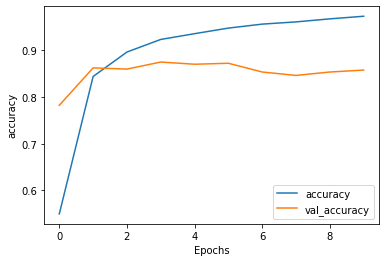

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

plot_graphs(history, 'accuracy')

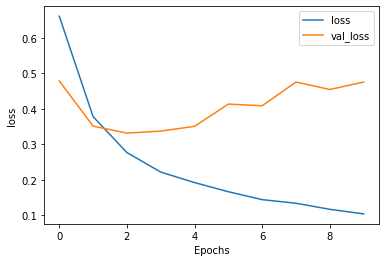

In [ ]:
plot_graphs(history, 'loss')